In [1]:
import requests
from PIL import Image

urls = ["https://storage.googleapis.com/perceiver_io/sintel_frame1.png", "https://storage.googleapis.com/perceiver_io/sintel_frame2.png"]

image1 = Image.open(requests.get(urls[0], stream=True).raw)
image2 = Image.open(requests.get(urls[1], stream=True).raw)

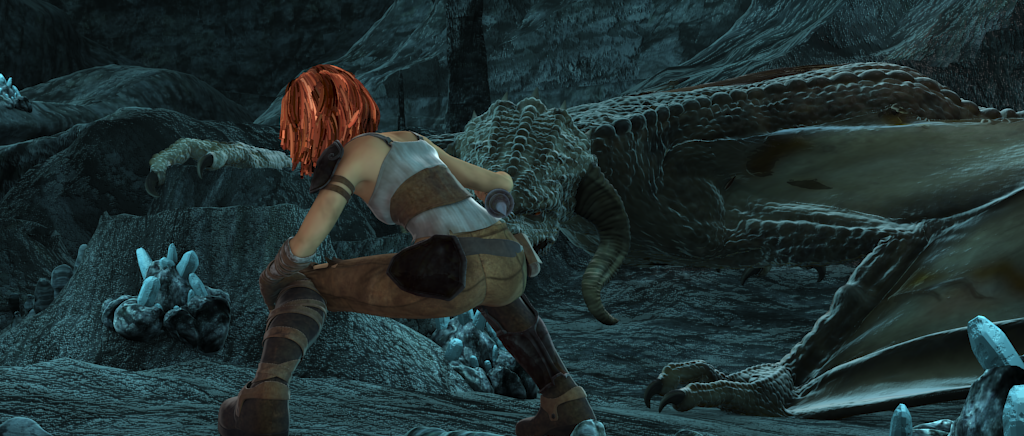

In [2]:
display(image1)

In [3]:
import math
import torch.nn.functional as F

def normalize(im):
  return im / 255.0 * 2 - 1

# source: https://discuss.pytorch.org/t/tf-extract-image-patches-in-pytorch/43837/9
def extract_image_patches(x, kernel, stride=1, dilation=1):
    # Do TF 'SAME' Padding
    b,c,h,w = x.shape
    h2 = math.ceil(h / stride)
    w2 = math.ceil(w / stride)
    pad_row = (h2 - 1) * stride + (kernel - 1) * dilation + 1 - h
    pad_col = (w2 - 1) * stride + (kernel - 1) * dilation + 1 - w
    x = F.pad(x, (pad_row//2, pad_row - pad_row//2, pad_col//2, pad_col - pad_col//2))
    
    # Extract patches
    patches = x.unfold(2, kernel, stride).unfold(3, kernel, stride)
    patches = patches.permute(0,4,5,1,2,3).contiguous()
    
    return patches.view(b,-1,patches.shape[-2], patches.shape[-1])

In [4]:
import torch
import numpy as np

def compute_optical_flow(model, img1, img2, grid_indices, FLOW_SCALE_FACTOR = 20):
  """Function to compute optical flow between two images.

  To compute the flow between images of arbitrary sizes, we divide the image
  into patches, compute the flow for each patch, and stitch the flows together.

  Args:
    model: PyTorch Perceiver model 
    img1: first image
    img2: second image
    grid_indices: indices of the upper left corner for each patch.
  """
  img1 = torch.tensor(np.moveaxis(img1, -1, 0))
  img2 = torch.tensor(np.moveaxis(img2, -1, 0))
  imgs = torch.stack([img1, img2], dim=0)[None]
  height = imgs.shape[-2]
  width = imgs.shape[-1]

  #print("Shape of imgs after stacking:", imgs.shape)

  patch_size = model.config.train_size
  
  if height < patch_size[0]:
    raise ValueError(
        f"Height of image (shape: {imgs.shape}) must be at least {patch_size[0]}."
        "Please pad or resize your image to the minimum dimension."
    )
  if width < patch_size[1]:
    raise ValueError(
        f"Width of image (shape: {imgs.shape}) must be at least {patch_size[1]}."
        "Please pad or resize your image to the minimum dimension."
    )

  flows = 0
  flow_count = 0

  for y, x in grid_indices:    
    imgs = torch.stack([img1, img2], dim=0)[None]
    inp_piece = imgs[..., y : y + patch_size[0],
                     x : x + patch_size[1]]
        
    print("Shape of inp_piece:", inp_piece.shape)
    
    batch_size, _, C, H, W = inp_piece.shape
    patches = extract_image_patches(inp_piece.view(batch_size*2,C,H,W), kernel=3)
    _, C, H, W = patches.shape
    patches = patches.view(batch_size, -1, C, H, W).float().to(model.device)
        
    # actual forward pass
    with torch.no_grad():
      output = model(inputs=patches).logits * FLOW_SCALE_FACTOR
    
    # the code below could also be implemented in PyTorch
    flow_piece = output.cpu().detach().numpy()
    
    weights_x, weights_y = np.meshgrid(
        torch.arange(patch_size[1]), torch.arange(patch_size[0]))

    weights_x = np.minimum(weights_x + 1, patch_size[1] - weights_x)
    weights_y = np.minimum(weights_y + 1, patch_size[0] - weights_y)
    weights = np.minimum(weights_x, weights_y)[np.newaxis, :, :,
                                                np.newaxis]
    padding = [(0, 0), (y, height - y - patch_size[0]),
               (x, width - x - patch_size[1]), (0, 0)]
    flows += np.pad(flow_piece * weights, padding)
    flow_count += np.pad(weights, padding)

    # delete activations to avoid OOM
    del output

  flows /= flow_count
  return flows

In [5]:
from transformers import PerceiverForOpticalFlow
import torch

device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PerceiverForOpticalFlow.from_pretrained("deepmind/optical-flow-perceiver")
model = model.to(device)

c:\Users\Johan\Documents\Projects\Python\DestripaFrames\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import itertools

TRAIN_SIZE = model.config.train_size

def compute_grid_indices(image_shape, patch_size=TRAIN_SIZE, min_overlap=20):
  if min_overlap >= TRAIN_SIZE[0] or min_overlap >= TRAIN_SIZE[1]:
    raise ValueError(
        f"Overlap should be less than size of patch (got {min_overlap}"
        f"for patch size {patch_size}).")
  ys = list(range(0, image_shape[0], TRAIN_SIZE[0] - min_overlap))
  xs = list(range(0, image_shape[1], TRAIN_SIZE[1] - min_overlap))
  # Make sure the final patch is flush with the image boundary
  ys[-1] = image_shape[0] - patch_size[0]
  xs[-1] = image_shape[1] - patch_size[1]
  return itertools.product(ys, xs)
     

In [7]:
im1 = np.array(image1)
im2 = np.array(image2)

# Divide images into patches, compute flow between corresponding patches
# of both images, and stitch the flows together
grid_indices = compute_grid_indices(im1.shape)
flow = compute_optical_flow(model, normalize(im1), normalize(im2), grid_indices)

Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])
Shape of inp_piece: torch.Size([1, 2, 3, 368, 496])


In [8]:
import cv2
import matplotlib.pyplot as plt

def visualize_flow(flow):
  flow = np.array(flow)
  # Use Hue, Saturation, Value colour model 
  hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
  hsv[..., 2] = 255

  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  hsv[..., 0] = ang / np.pi / 2 * 180
  hsv[..., 1] = np.clip(mag * 255 / 24, 0, 255)
  bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  plt.imshow(bgr)

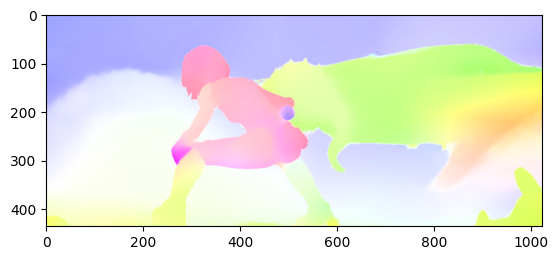

In [9]:
visualize_flow(flow[0])

In [3]:
import cv2

vVideoCapture = cv2.VideoCapture("C:/Users/Johan/Downloads/OpenposeBone/video.mp4")
vSucces, vFrame = vVideoCapture.read()

vIndex = 0
while vSucces:
    print("\r>>", vIndex, end = "")
    vSucces, vFrame = vVideoCapture.read()
    vIndex = vIndex + 1

>> 326